In [3]:
#!/usr/bin/python
import os, math, sys, random
import numpy as np
import numpy.linalg as la
import scipy.stats as st
import scipy.optimize as sopt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
# import pyDOE as doe
from scipy.special import legendre
from scipy import integrate
random.seed(106) # fixing the random seed

In [4]:
startName = 'c'
mcmcInstName = '1'
indAlp = [0,1,2]
logri = -20
logsi = -20
plotmpdf = 1
savefiles = 0
grdGen = 1

In [5]:
if startName ==   'a':
    LogAlp0 = [-10,-10,-10]
elif startName == 'b':
    LogAlp0 = [5,5,5]
elif startName == 'c':
    LogAlp0 = [0,0,0]
elif startName == 'd':
    LogAlp0 = [20,20,20]

LogAlp0 = np.random.uniform(-10,10,3)

print(LogAlp0)

[ 9.37538236  6.05464901 -7.579342  ]


In [6]:
KDE = 1
if KDE == 1:
    samples = np.loadtxt('../chains/ModelSIRS_Full-posterior.dat')
    sort_indices = np.argsort(samples[2, :])
    muVec = samples[:, sort_indices]
    print(muVec.shape)

    muVec = muVec[:,10000:990000:980]
    print(muVec.shape)

    Nphi   = muVec.shape[0] 
    K   = muVec.shape[1]
    kdeMCMC= st.gaussian_kde(muVec)#,bw_method = 0.001)
    SigMat = kdeMCMC.covariance
    np.savetxt('muVec.dat',muVec)
    np.savetxt('SigMat.dat',SigMat)


muVec = np.loadtxt('muVec.dat')
sigMat = np.loadtxt('SigMat.dat')
sigMatOrig = np.copy(sigMat)
#aCoeff = np.loadtxt('aCoeff.dat')
aCoeff = [1.0]*K
Nalp = len(indAlp)
sigMatAlp = np.copy(sigMat[0:Nalp,0:Nalp])
Ck = np.copy(sigMat[0:Nalp,Nalp:])
muVecAlp     = np.copy(muVec[0:Nalp,:])
rCoeff = np.exp(logri)*np.ones((1,Nalp)) 
sCoeff = np.exp(logsi)*np.ones((1,Nalp))

(5, 1000000)
(5, 1000)


In [7]:
# from sklearn.mixture import GaussianMixture


# gmm = GaussianMixture(n_components=1, covariance_type='full', reg_covar=1e-6)
# gmm.fit(muVec.T)

# from scipy.stats import norm
# mpl.rcParams.update({'font.size':10})

# Ngrd = 251
# for i in range(len(muVec[:,0])):
#     mu = gmm.means_[i]
#     std = np.sqrt(gmm.covariances_[i,i])
#     minX = mu-3*std
#     maxX = mu+3*std

#     # minX = min(min(mVec[i,:]),min(muVec[i,:]))
#     # maxX = max(max(mVec[i,:]),max(muVec[i,:]))
#     print(minX,maxX)
#     Xgrd = np.linspace(minX,maxX,Ngrd)

#     fig = plt.figure(i+3, figsize=(2, 2))
#     plt.plot(Xgrd,norm.pdf(Xgrd,mu,scale=std),linewidth=2)  #/np.max(XPrePdf(Xgrd))
#     plt.hist(muVec[i,:],bins=50,density=True,alpha=0.5)
#     plt.xlim(minX,maxX)
#     myticks = [minX, (minX+maxX)/2,maxX]
#     plt.xticks(myticks)
#     plt.yticks([])
#     plt.xlabel(mylabel[i], fontsize=12)
#     # myticksY = [0, maxY/2,maxY]
#     # plt.yticks(myticksY)
#     # plt.ticklabel_format(style='sci', axis='y', scilimits=(-1,1.01))
#     # if i==1: 
#     #     plt.legend(loc='upper left', numpoints = 1, ncol=4, prop={'size':12})
#     plt.grid(True)
#     # plt.savefig('mpdf_'+startName+'_'+ str(i) + '.pdf',bbox_inches='tight')
    

In [8]:
def NSBL(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
#     Bmat = np.zeros((Nphi,Nphi,K))
#     Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nalp,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nalp,K))
    rVec = np.zeros((Nalp,K))
    rVecSum = np.zeros((Nalp,1))
    vbarVec = np.zeros((Nalp,1))
    jVec = np.zeros((Nalp,1))
    Hmat = np.zeros((Nalp,Nalp))
    Bmat = sigMatAlp + Ainv
    Pmat = Ainv - Ainv@la.inv(Bmat)@Ainv
    for k in range(0,K):
        mVec[:,k]   = Pmat@la.inv(sigMatAlp)@muVecAlp[:,k]
        wVec[0,k]   = aCoeff[k]*st.multivariate_normal.pdf(muVecAlp[:,k],[0]*Nalp,Bmat)
        for ii in range(0,Nalp):
            vVec[ii,k] = 0.5*(1.0 - alp[ii]*(Pmat[ii,ii] + mVec[ii,k]**2))
            rVec[ii,k] = 1.0 - alp[ii]*Pmat[ii,ii]
            rVecSum[ii,0] = rVecSum[ii,0] + rVec[ii,k]**2
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    for ii in range(0,Nalp):
        vbarVec[ii,0] = np.dot(wVec[0,:],vVec[ii,:])
        jVec[ii,0]   = vbarVec[ii,0] + rCoeff[0,ii] - sCoeff[0,ii]*alp[ii]
        for jj in range(0,ii):
            Hmat[ii,jj] = Hmat[jj,ii]
        for jj in range(ii,Nalp):
            tmpij = 1.0 if ii==jj else 0.0
            for k in range(0,K):
                Hmat[ii,jj] = Hmat[ii,jj] + wVec[0,k]*(alp[ii]*alp[jj]*(0.5*Pmat[ii,jj]**2 \
                                    + mVec[ii,k]*mVec[jj,k]*Pmat[ii,jj]) \
                                    + vVec[jj,k]*(vVec[ii,k] - vbarVec[ii,0]))
            Hmat[ii,jj] = Hmat[ii,jj] + tmpij*(vbarVec[ii,0] - sCoeff[0,ii]*alp[ii] - 0.5)
    return np.log(evid), objFun, jVec[:,0], Hmat, np.sqrt(rVecSum[:,0]/K)
def NSBLmod(logalpIN):
    alp = np.exp(logalpIN)
    A = np.diag(alp)
    Ainv = np.diag(1/alp)
#     Bmat = np.zeros((Nphi,Nphi,K))
#     Pmat = np.zeros((Nphi,Nphi,K))
    mVec = np.zeros((Nalp,K))
    wVec = np.zeros((1,K))
    vVec = np.zeros((Nalp,K))
    rVec = np.zeros((Nalp,K))
    rVecSum = np.zeros((Nalp,1))
    vbarVec = np.zeros((Nalp,1))
    jVec = np.zeros((Nalp,1))
    Hmat = np.zeros((Nalp,Nalp))
    Bmat = sigMatAlp + Ainv
    Pmat = Ainv - Ainv@la.inv(Bmat)@Ainv
    for k in range(0,K):
        mVec[:,k]   = Pmat@la.inv(sigMatAlp)@muVecAlp[:,k]
        wVec[0,k]   = aCoeff[k]*st.multivariate_normal.pdf(muVecAlp[:,k],[0]*Nalp,Bmat)
    evid = np.sum(wVec)
    wVec = wVec/evid
    objFun = np.log(evid) + np.dot(rCoeff[0,:],logalpIN) - np.dot(sCoeff[0,:],alp)
    return np.log(evid), objFun

In [9]:
def myFun(xin):
    _, Otmp, Jtmp, _,_ = NSBL(xin)
    return -Otmp, -Jtmp
def myFunb(xin):
    _, Otmp, _, _,_ = NSBL(xin)
    return -Otmp
def myFunHess(xin):
    _, _, _, Htmp,_ = NSBL(xin)
    return -Htmp
maxIter = 50
ftol = 1e-08
jtol = 1e-08
res = sopt.minimize(myFun, LogAlp0, method='trust-ncg',jac=True, hess=myFunHess, \
                    options={'maxiter':maxIter,'return_all': True,'gtol':jtol})
print(res)

 allvecs: [array([ 9.37538236,  6.05464901, -7.579342  ]), array([ 9.36547936,  5.09870813, -7.42995267]), array([ 9.36902844,  4.2375602 , -6.92161061]), array([ 9.40330256,  3.69033424, -4.99823623]), array([ 9.48094362,  4.66797327, -1.12032521]), array([9.61923915, 3.6248235 , 6.81016739]), array([9.61923915, 3.6248235 , 6.81016739]), array([ 9.68356426,  4.79777722, 10.63378372]), array([ 9.68687598,  4.243683  , 10.65947783]), array([ 9.6969539 ,  4.02935944, 10.67553365]), array([10.69363274,  3.99930119, 10.67433514]), array([11.62330658,  3.99909684, 10.67657466]), array([12.25068214,  3.99920782, 10.67660146]), array([12.36042073,  3.99928463, 10.67662328]), array([12.36087017,  3.99928684, 10.6766239 ])]
     fun: -13.063702252634247
    hess: array([[ 9.62691726e-04,  1.84022899e-04,  4.38895721e-05],
       [ 1.84022899e-04,  4.96317014e-01, -7.25018982e-03],
       [ 4.38895721e-05, -7.25018982e-03,  4.40090408e-01]])
     jac: array([-2.81031275e-13, -1.68134994e-11, -4.

In [10]:
LogAlpIter = np.zeros((res.nit,Nalp))
fevalIter = np.zeros((res.nit,2))
rVecIter = np.zeros((res.nit,Nalp))
for i in range(0,res.nit):
    LogAlpIter[i,:] = res.allvecs[i]
    fevalIter[i,0], fevalIter[i,1], _, _, rVecIter[i,:] = NSBL(LogAlpIter[i,:])
print('[{0:7.2f},{1:7.2f},{6:5.2f},{2:12.4e},{3:12.4e},{4:12.4e},{5:12.4e}]'.format(\
    logri,logsi,fevalIter[-1,0], fevalIter[-1,1], rVecIter[-1,0],res.x[0],res.nit))
if savefiles == 1:
    np.savetxt('data'+str(int(K))+'/rVecdata'+mcmcInstName+startName+'.dat',rVecIter)
    np.savetxt('data'+str(int(K))+'/LogAlpIter'+mcmcInstName+startName+'.dat',LogAlpIter)
    np.savetxt('data'+str(int(K))+'/fevalIter'+mcmcInstName+startName+'.dat',fevalIter)

print(rVecIter[-1,:])

[ -20.00, -20.00,14.00,  1.3064e+01,  1.3064e+01,  3.4340e-03,  1.2361e+01]
[0.00343399 0.99811538 0.97297688]


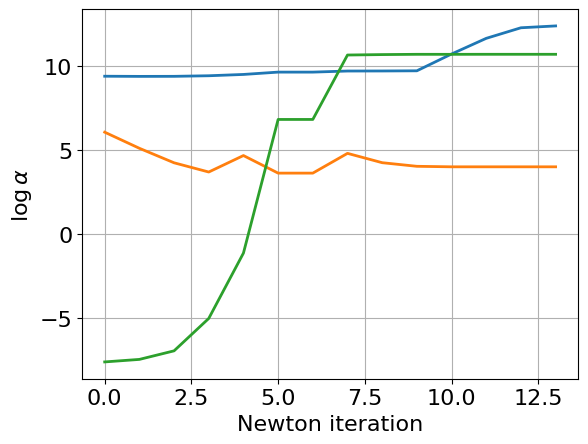

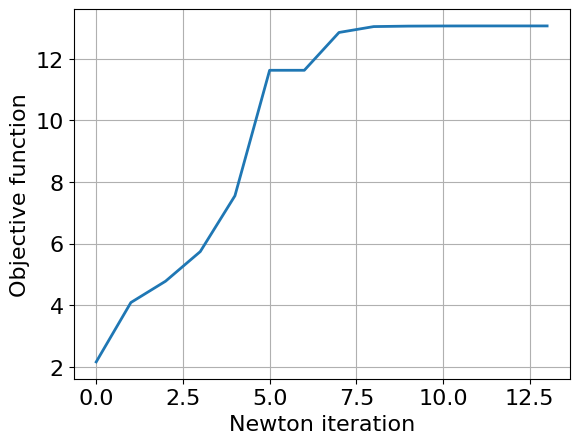

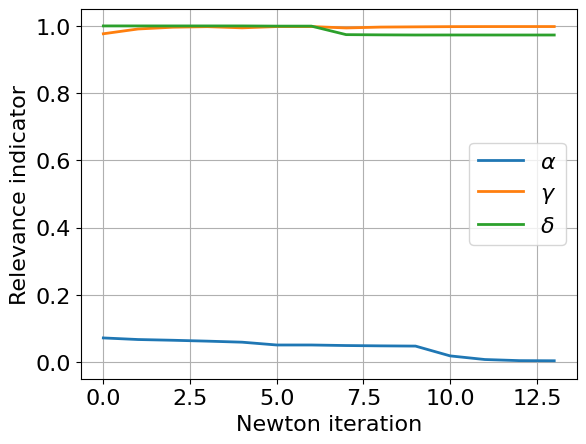

In [11]:
mpl.rcParams.update({'font.size':16})
lwid = 2.0
mylabel = [r'$\alpha$',r'$\gamma$',r'$\delta$',r'$q_\xi$',r'$\beta_0$']
fig=plt.figure(2)
for i in range(0,Nalp):
    plt.plot(LogAlpIter[:,i],label=mylabel[i],linewidth=lwid)
plt.ylabel(r'$\log\alpha$')
plt.grid(True)
# plt.xlim([0,10])
# plt.ylim([-10,10])
#plt.ylim([-10,10.0])
# plt.xticks(np.linspace(0,10,6))
plt.xlabel('Newton iteration')
# plt.legend(loc='center right', numpoints = 1)
plt.savefig('plot_logalphaiter_'+startName+'.pdf',bbox_inches='tight')

fig=plt.figure(3)
# plt.plot(fevalIter[:,0],'r-',label='Log-evidence')
plt.plot(fevalIter[:,1],linewidth=lwid)#,'b-',label='Objective function')
plt.grid(True)
# plt.xlim([0,10])
# plt.ylim([-275,25])
plt.ylabel('Objective function')
# plt.ylim([-500,6.0])
# plt.xticks(np.linspace(0,10,6))
plt.xlabel('Newton iteration')
# plt.legend(loc='lower right', numpoints = 1)
plt.savefig('plot_logevid_'+startName+'.pdf',bbox_inches='tight')

fig=plt.figure(4)
for i in range(0,Nalp):
    plt.plot(rVecIter[:,i],label=mylabel[i],linewidth=lwid)
plt.grid(True)
# plt.xlim([0,res.nit])
plt.ylim([-0.05,1.05])
# plt.xlim([0,10])
# plt.xticks(np.linspace(0,10,6))
plt.ylabel('Relevance indicator')
plt.xlabel('Newton iteration')
plt.legend(loc='center right', numpoints = 1)
plt.savefig('plot_sparse_'+startName+'.pdf',bbox_inches='tight')

In [12]:
# Optimal alpha
# 12.36087017,  3.99928684, 10.6766239 

grdGen = 0
Ngrd  = 100
# LogAlp2bnd = [-12.5,7.5]
LogAlp1bnd = [-5,25]
LogAlp2bnd = [-5,25]
LogAlpCur = np.array([0.0]*3)
if grdGen ==1:
    LogEvidgrd  = np.zeros((Ngrd,Ngrd))
    ObjFungrd   = np.zeros((Ngrd,Ngrd))
    RelIndgrd   = np.zeros((Ngrd,Ngrd,Nalp))
    LogAlp1rng = np.linspace(LogAlp1bnd[0],LogAlp1bnd[1],Ngrd)
    LogAlp2rng  = np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],Ngrd)
    LogAlp1grd,LogAlp2grd = np.meshgrid(LogAlp1rng,LogAlp2rng)
    for i in range(0,Ngrd):
        for j in range(0, Ngrd):
            LogAlpCur[0] = LogAlp1grd[i,j]
            LogAlpCur[1] = LogAlp2grd[i,j]
            LogAlpCur[2] = 10.6766239 
            LogEvidgrd[i,j], ObjFungrd[i,j], _, _, RelIndgrd[i,j,:] = NSBL(LogAlpCur)
    np.savetxt('LogAlp1grd_3.dat',LogAlp1grd)
    np.savetxt('LogAlp2grd_3.dat',LogAlp2grd)
    np.savetxt('LogEvidgrd_3.dat',LogEvidgrd)
    np.savetxt('ObjFungrd_3.dat',ObjFungrd)
else:
    LogAlp1grd = np.loadtxt('LogAlp1grd_1.dat')
    LogAlp2grd = np.loadtxt('LogAlp2grd_1.dat')
    ObjFungrd  = np.loadtxt('ObjFungrd_1.dat')
    LogEvidgrd  = np.loadtxt('LogEvidgrd_1.dat')

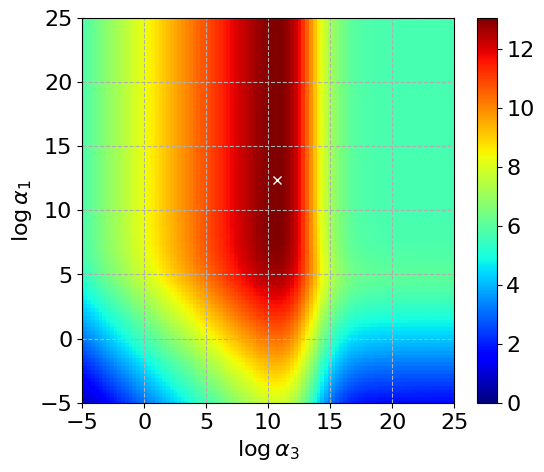

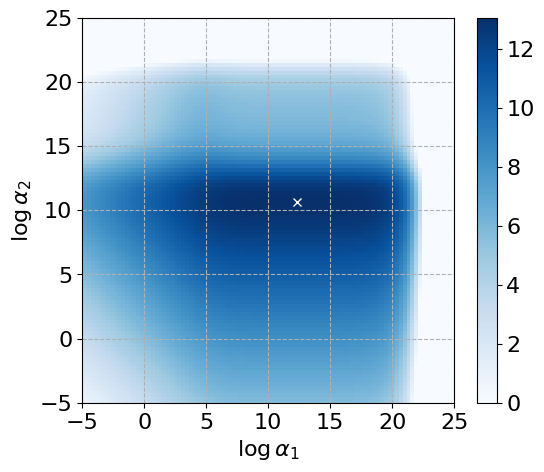

In [13]:
mpl.rcParams.update({'font.size':16})

opt = 12.36087017,  10.6766239
# opt = 3.99928684, 10.6766239 
# opt = 12.36087017,  3.99928684


f, ax = plt.subplots(1, figsize=(6,5))
plt.pcolor(LogAlp2grd,LogAlp1grd,LogEvidgrd,cmap='jet',vmin=0)
plt.plot(opt[1],opt[0],'x',c='w')
plt.colorbar()
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_3$')
plt.ylabel(r'$\log\alpha_1$')
plt.xticks(np.linspace(LogAlp1bnd[0],LogAlp1bnd[1],7))
plt.yticks(np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],7))
plt.savefig('figs/NSBL_evidence_1.pdf',bbox_inches='tight')


f, ax = plt.subplots(1, figsize=(6,5))
plt.pcolor(LogAlp1grd,LogAlp2grd,ObjFungrd,cmap='Blues',vmin=0)
plt.plot(opt[0],opt[1],'x',c='w')
plt.colorbar()
plt.xlim([0,10])
plt.ylim([0,10])
plt.grid('on',linestyle='--')
plt.xlabel(r'$\log\alpha_1$')
plt.ylabel(r'$\log\alpha_2$')
plt.xticks(np.linspace(LogAlp1bnd[0],LogAlp1bnd[1],7))
plt.yticks(np.linspace(LogAlp2bnd[0],LogAlp2bnd[1],7))
plt.savefig('figs/NSBL_objective_1.pdf',bbox_inches='tight')

# for ii in range(num_start):
#   it_cur = iterations[ii]
#   it1 = it_cur[2::4]
#   it2 = it_cur[3::4]
#   # plt.plot(it1[0],it2[0],'ko')
#   plt.plot(it1[-1],it2[-1],'wx')
#   # plt.plot(it1,it2,'k--',linewidth=1)


In [14]:
# compute posterior pdf
muVec = samples[:,::10]
Nphi   = muVec.shape[0] 
K   = muVec.shape[1]
print(np.shape(muVec))

logalpMap = np.asarray(res.x)
alpMap = np.exp(logalpMap)
A = np.diag(alpMap)
Ainv = np.diag(1/alpMap)
Bmat = np.asarray(sigMatAlp + Ainv)
BmatInv = la.inv(Bmat)
mChangeMat = np.zeros((Nphi,Nphi))
tempMat1 = sigMatAlp@BmatInv
tempMat2 = Ck.T@BmatInv
mChangeMat[0:Nalp,0:Nalp] = np.copy(tempMat1)
mChangeMat[Nalp:,0:Nalp] = np.copy(tempMat2)
mVec = np.zeros((Nphi,K))
PmatNew = np.zeros((Nphi,Nphi,K))
muVecAlp = np.asarray(muVec[0:Nalp,:])
wVec = np.zeros((1,K))
#print(np.shape(tempMat1),np.shape(BmatInv),np.shape(Ck))
for k in range(0,K):
    wVec[0,k]   = st.multivariate_normal.pdf(muVecAlp[:,k],[0]*Nalp,Bmat)
    mVec[:,k] = muVec[:,k] - mChangeMat@muVec[:,k]
    PmatNew[0:Nalp,0:Nalp,k] = sigMatAlp - tempMat1*sigMatAlp
    PmatNew[Nalp:,Nalp:,k] = sigMat[Nalp:,Nalp:] - tempMat2@Ck
#     PmatNew[0:Nalp,Nalp:,k] = tempMat1@muVecAlp@muVecAlp@BmatInv@Ck
    PmatNew[0:Nalp,Nalp:,k] = muVecAlp[:,k]*muVecAlp[:,k]*tempMat1@BmatInv@Ck
    PmatNew[Nalp:,0:Nalp,k] = muVecAlp[:,k]*muVecAlp[:,k]*(tempMat1@BmatInv@Ck).T
wVecSum = np.sum(wVec)
wVec = wVec/wVecSum

(5, 100000)


In [15]:
# np.savetxt('mVec.dat',mVec)

# mVec_rel = np.copy(mVec)
# mVec_rel = np.delete(mVec_rel,2,0)
# mVec_rel = np.delete(mVec_rel,2,0)

# from scipy.optimize import minimize
# kde = st.gaussian_kde(mVec_rel)
# def kde_fun(x):
#   return -kde(x)
# res = minimize(kde_fun,[100,-500,0.2,-1.25,-1,0.002,0.0005], method='nelder-mead',options={'xatol': 1e-8, 'disp': True})
# print(res.x)
# maps = res.x
# #np.savetxt('Case00Model1-map.dat')

# for i in range(len(muVec[:,0])):
#     print(np.mean(muVec[i,:]),np.std(muVec[i,:]))

print(np.shape(wVec[0,:]),np.shape(mVec[0,:]))

for i in range(len(muVec[:,0])):
    print(np.mean(muVec[i,:]),np.std(muVec[i,:]))

    print(np.average(mVec[i,:],weights=wVec[0,:]),np.sqrt(np.average((mVec[i,:]-np.average(mVec[i,:],weights=wVec[0,:]))**2,weights=wVec[0,:])))

(100000,) (100000,)
-0.012851395648668617 0.08447389202430157
5.69288868989359e-05 8.615504798935991e-05
0.14944567828748115 0.05607326853043823
0.13510290947592393 0.005539182964564186
0.007751980913073729 0.036902164162928026
0.0046520369181714 0.0007684490761624656
0.0007257993610720629 0.00023651326125065058
0.000631729377916217 0.00015775741419629582
0.17797664761427304 0.03658911581060123
0.17746661485544238 0.010963898676441122


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


(5, 100000)
(5, 100000)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

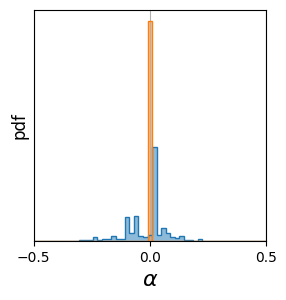

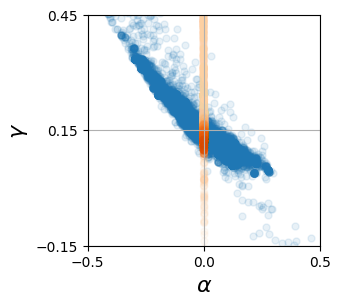

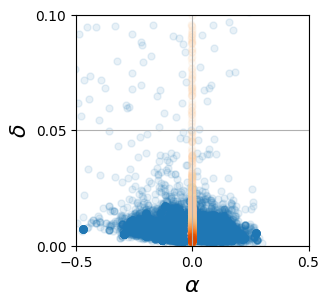

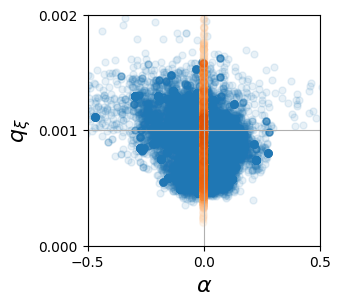

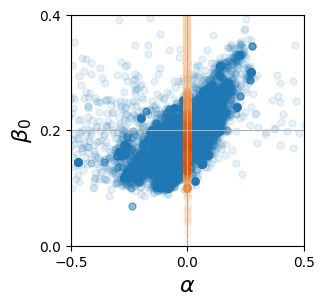

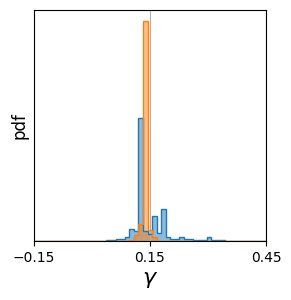

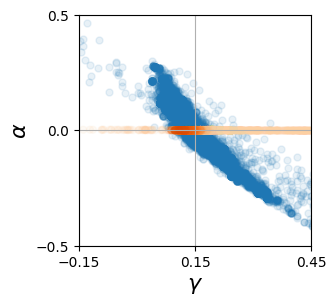

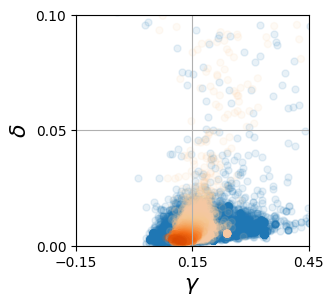

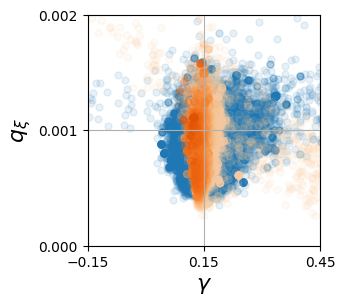

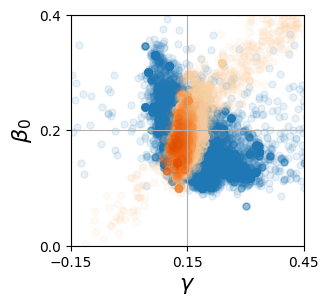

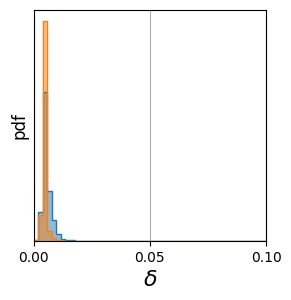

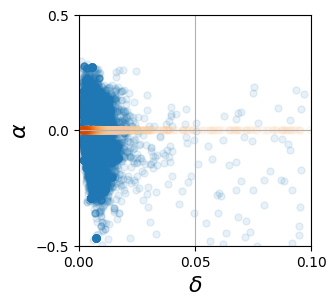

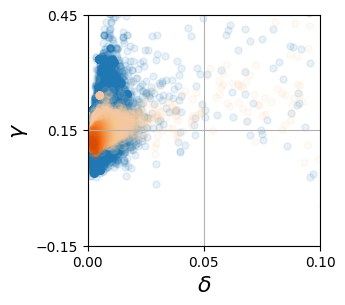

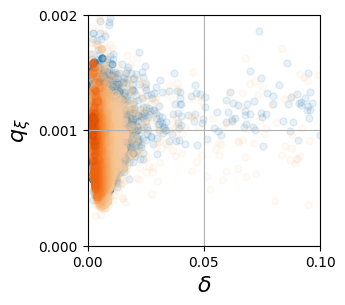

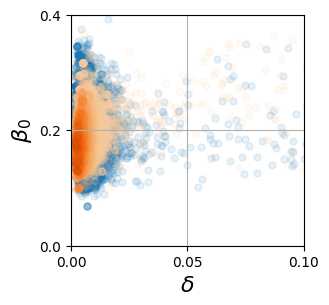

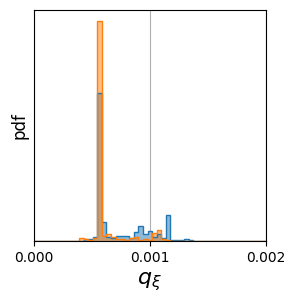

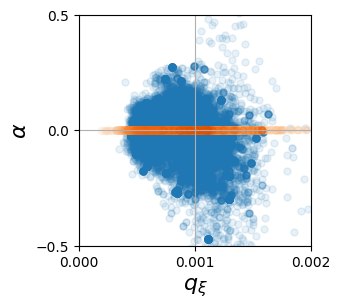

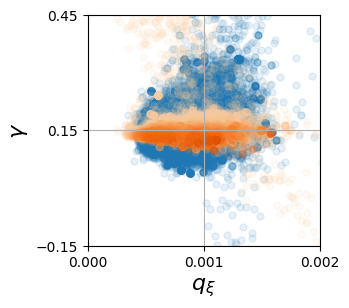

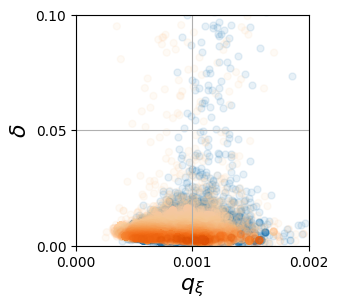

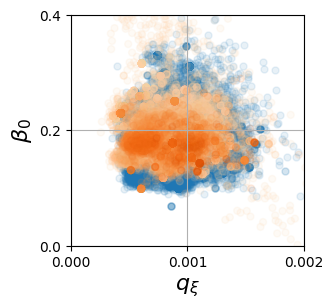

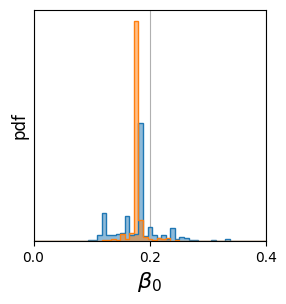

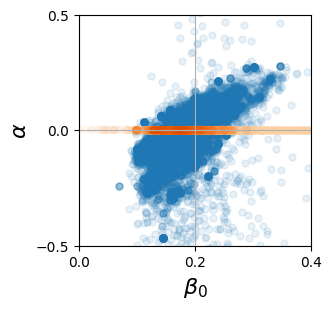

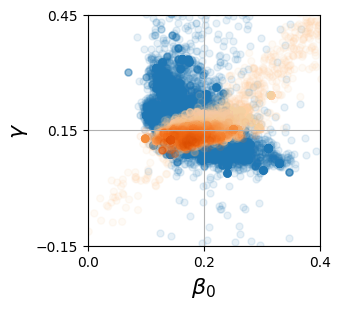

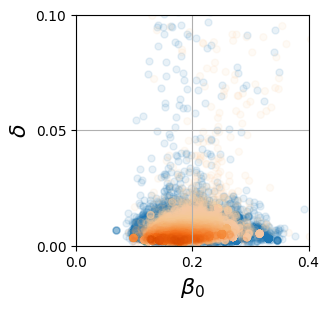

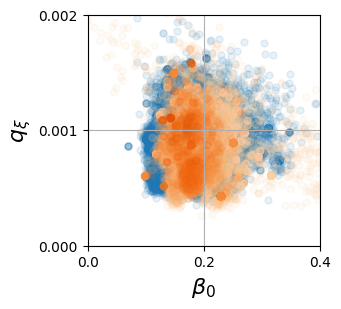

In [17]:
mpl.rcParams.update({'font.size':10})

sorted_indices = np.argsort(wVec)
muVec_sorted = muVec[:, sorted_indices]
mVec_sorted = mVec[:, sorted_indices]
wVec_sorted = wVec[:, sorted_indices]
print(np.shape(muVec))
print(np.shape(mVec))

skip = 2000
Ngrd = 251

xlow = [-0.5,-0.15, 0, 0, 0] 
xup = [0.5, 0.45, 0.1, 0.002, 0.4]

for ii in range(len(muVec[:,0])):
    f, ax = plt.subplots(1, figsize=(3,3))
    ax = fig.add_subplot(1, 1, 1)

    minX = xlow[ii]
    maxX = xup[ii]
    # minX = min(min(mVec[i,:]),min(muVec[i,:]))
    # maxX = max(max(mVec[i,:]),max(muVec[i,:]))
    # print(minX,maxX)
    Xgrd = np.linspace(minX,maxX,Ngrd)


    # XPostPdf = st.kde.gaussian_kde(mVec[ii,:],bw_method = bw_post[i])
    # XPrePdf = st.kde.gaussian_kde(muVec[ii,:],bw_method = bw_pre[i]) 
    # plt.plot(Xgrd,XPrePdf(Xgrd),linewidth=2,label='pre-NSBL')
    # plt.plot(Xgrd,XPostPdf(Xgrd),linewidth=2,label='post-NSBL')
    # maxY = np.max([XPrePdf(Xgrd),XPostPdf(Xgrd)])

    binwidth = (xup[ii] - xlow[ii])/51

    plt.hist(muVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,alpha=0.5)
    plt.hist(muVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,histtype='step',color='tab:blue')
    plt.hist(mVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,alpha=0.5,weights=wVec[0,:])
    plt.hist(mVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,histtype='step',color='tab:orange',weights=wVec[0,:])
    plt.xlabel(mylabel[ii], fontsize=16)
    # zzt = [phiTrue[i],phiTrue[i]]
    # mylim = ax.get_ylim()

    # maxY = yup[i]
    # maxY = max(XPrePdf(Xgrd))
    # maxY = mylim[1]
    # plt.plot(zzt,[0,1.1*maxY],'--k',label='True')
    plt.ylabel('pdf',fontsize=12)
    plt.grid(True)
    # plt.ylim([0,1.1*maxY])
    # plt.ylim([0,1.1*maxY])
    plt.xlim(minX,maxX)
    myticks = [minX, (minX+maxX)/2,maxX]
    plt.xticks(myticks)
    # myticksY = [0, maxY/2,maxY]
    # plt.yticks(myticksY)
    plt.yticks([])
    # plt.savefig('figs/mpdf_'+ str(ii)+'.pdf',bbox_inches='tight')
    # plt.savefig('figs/mpdf_'+ str(ii)+'.png',bbox_inches='tight')
    plt.savefig('figs/mpdf_'+ str(ii)+'tight.png', format='eps', dpi=300,bbox_inches='tight')


    for jj in range(len(muVec[:,0])):
      if ii != jj:     
          minY = xlow[jj]
          maxY = xup[jj]

          f, ax = plt.subplots(1, figsize=(3,3))
          # if ii > jj:
          #   plt.scatter(muVec_sorted[ii,::skip],muVec_sorted[jj,::skip],alpha=0.5,s=25)
          # else:
          #   plt.scatter(mVec_sorted[ii,::skip],mVec_sorted[jj,::skip],s=25,c=wVec_sorted[0,::skip],cmap='Oranges',vmin=0, vmax=1.5*np.max(wVec_sorted[0,::skip]),alpha=0.25)
          # plt.plot(muVec_sorted[ii,::skip],muVec_sorted[jj,::skip],'o',alpha=0.1,markersize=25,rasterized=True)
          # plt.plot(mVec_sorted[ii,::skip],mVec_sorted[jj,::skip],'o',markersize=25,c=wVec_sorted[0,::skip],cmap='Oranges',vmin=-0.5*np.max(wVec_sorted[0,::skip]), vmax=1.5*np.max(wVec_sorted[0,::skip]),alpha=0.1,rasterized=True)
          plt.scatter(muVec_sorted[ii,::skip],muVec_sorted[jj,::skip],alpha=0.1,s=25)
          plt.scatter(mVec_sorted[ii,::skip],mVec_sorted[jj,::skip],s=25,c=wVec_sorted[0,::skip],cmap='Oranges',vmin=-0.5*np.max(wVec_sorted[0,::skip]), vmax=1.5*np.max(wVec_sorted[0,::skip]),alpha=0.1)
          plt.xlim([xlow[ii],xup[ii]])
          plt.ylim([xlow[jj],xup[jj]])
          plt.xlabel(mylabel[ii],fontsize=16)
          plt.ylabel(mylabel[jj],fontsize=16)
          myticks = [minX, (minX+maxX)/2,maxX]
          plt.xticks(myticks)
          myticks = [minY, (minY+maxY)/2,maxY]
          plt.yticks(myticks)
          plt.grid(True)
          # plt.savefig('figs/jpdf_'+ str(ii)+'_'+str(jj)+'.pdf',bbox_inches='tight')
          # plt.savefig('figs/jpdf_'+ str(ii)+'_'+str(jj)+'.png',bbox_inches='tight')
          plt.savefig('figs/jpdf_'+ str(ii)+'_'+str(jj)+'tight.eps', format='eps', dpi=300, bbox_inches='tight')
          # plt.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


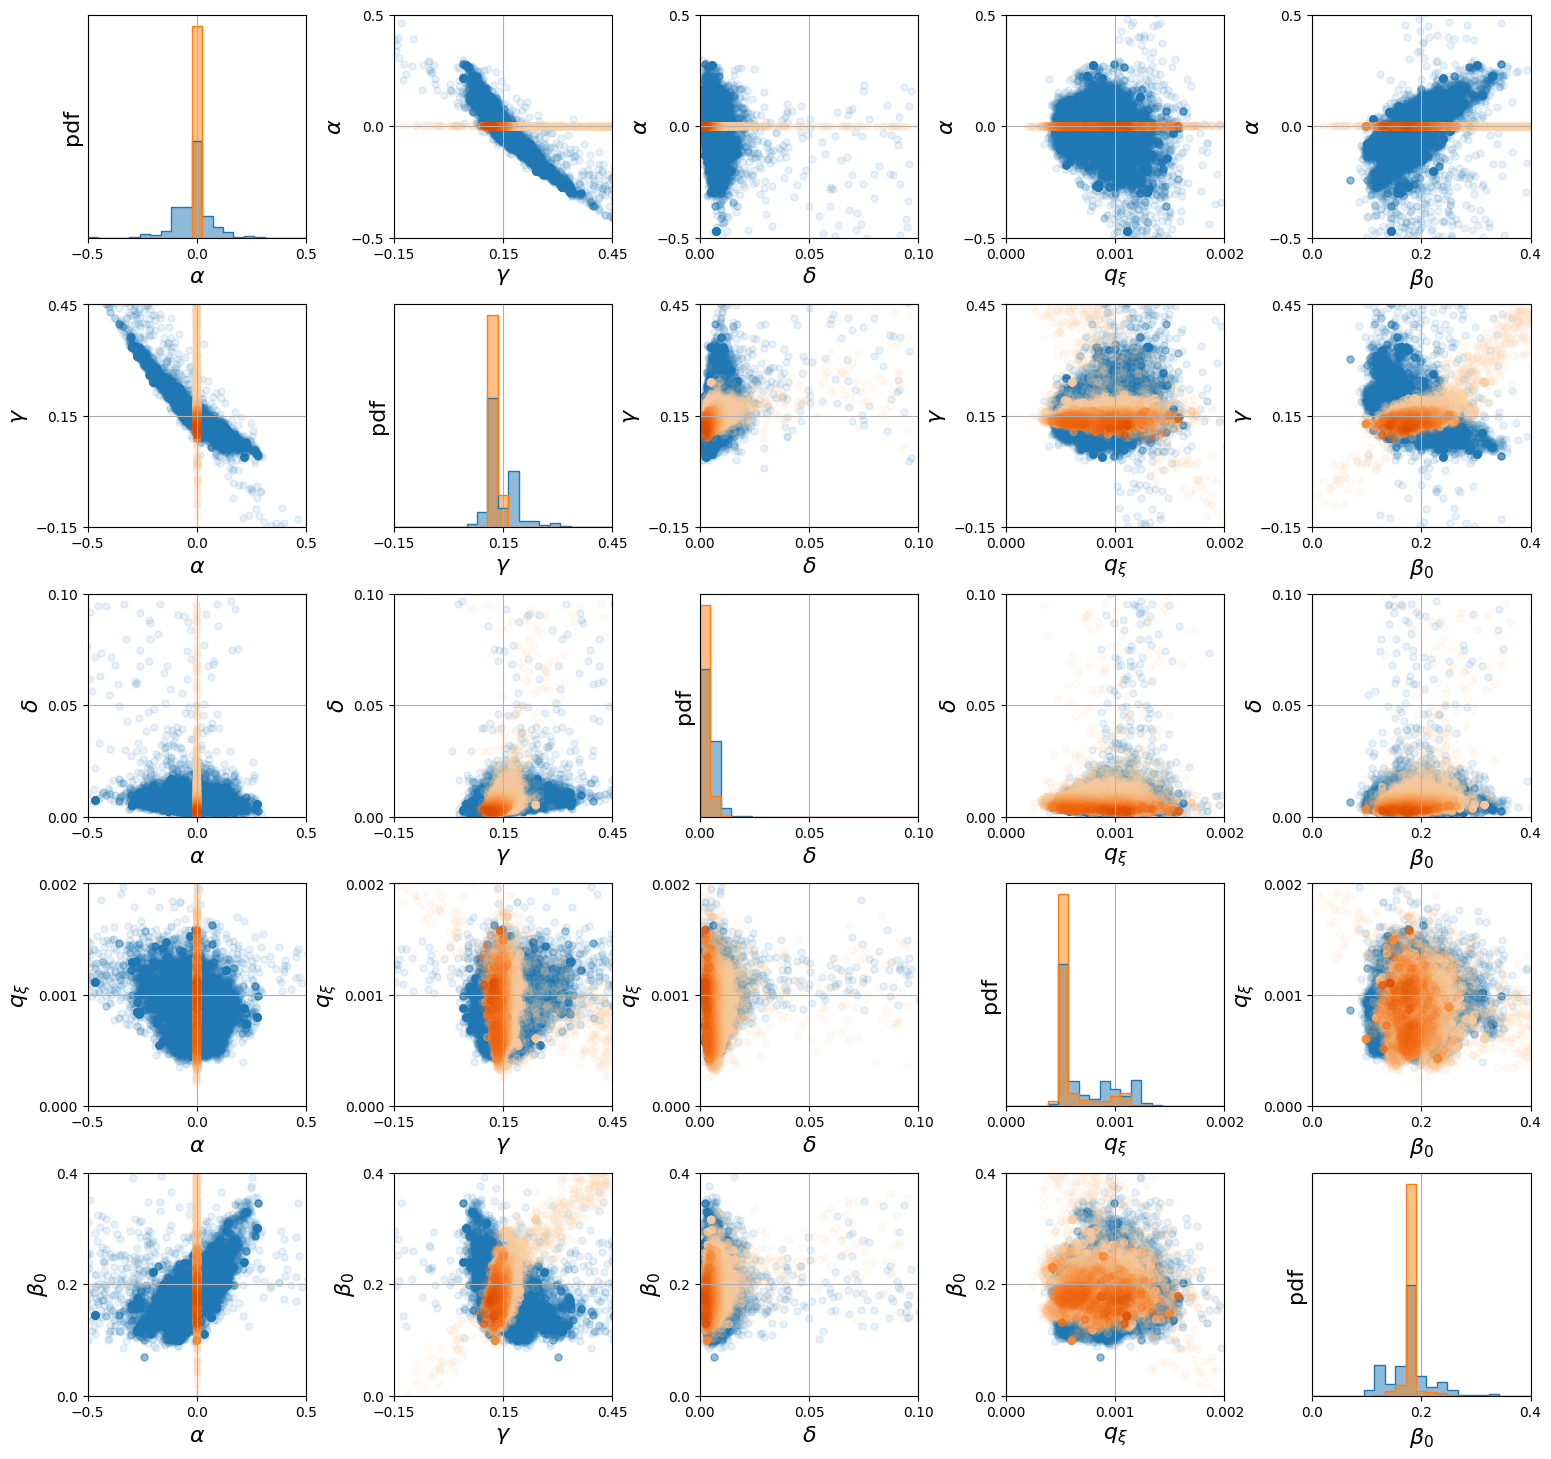

In [41]:
fig, axes = plt.subplots(nrows=5, ncols=5,figsize=(15.2,14.4)) #width, height (11.4,10.8)
fig.tight_layout()
plt.subplots_adjust(hspace=0.3, wspace=0.4) #spacing between rows, spacing between columns

fig_count = [0,5,10,15,20,1,6,11,16,21,2,7,12,17,22,3,8,13,18,23,4,9,14,19,24]
skip = 1
count = 0
for ii in range(5):
    x_low, x_up = xlow[ii],xup[ii]
    for jj in range(5):
        ax = axes.flat[fig_count[count]]
        y_low, y_up = xlow[jj], xup[jj]
        if ii == jj:
                    
          binwidth = (xup[ii] - xlow[ii])/21
          ax.hist(muVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,alpha=0.5)
          ax.hist(muVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,histtype='step',color='tab:blue')
          ax.hist(mVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,alpha=0.5,weights=wVec[0,:])
          ax.hist(mVec[ii,:],bins=np.arange(xlow[ii], xup[ii] + binwidth, binwidth),density=True,histtype='step',color='tab:orange',weights=wVec[0,:])
          ax.set_ylabel('pdf', fontsize=16)
          ax.set_xlabel(mylabel[ii], fontsize=16)
          ax.set_ylim(bottom=0)
          ax.set_xlim([x_low,x_up])
          ax.set_xticks([x_low,(x_low+x_up)/2,x_up])
          ax.set_yticks([])
          ax.grid(True)
        
        else:
          ax.scatter(muVec_sorted[ii,0,::skip],muVec_sorted[jj,0,::skip],alpha=0.1,s=25,rasterized=True)
          ax.scatter(mVec_sorted[ii,0,::skip],mVec_sorted[jj,0,::skip],s=25,c=wVec_sorted[0,0,::skip],cmap='Oranges',vmin=-0.5*np.max(wVec_sorted[0,0,::skip]), vmax=1.5*np.max(wVec_sorted[0,0,::skip]),alpha=0.1,rasterized=True)
          
          ax.set_xlim([x_low,x_up])
          ax.set_ylim([y_low,y_up])
          ax.set_xticks([x_low,(x_low+x_up)/2,x_up])
          ax.set_yticks([y_low,(y_low+y_up)/2,y_up])
          ax.grid(True)
          ax.set_xlabel(mylabel[ii],fontsize=16)
          ax.set_ylabel(mylabel[jj],fontsize=16)

        count+=1

# plt.savefig('figs/SIRS_pdfs.tiff',dpi=300,bbox_inches='tight')
# plt.savefig('figs/SIRS_pdfs.eps', format='eps', dpi=300,bbox_inches='tight')
plt.savefig('figs/SIRS_pdfs.pdf',bbox_inches='tight')


In [26]:
print(np.shape(mVec_sorted[ii,::skip]))
print(np.shape(mVec_sorted))
print(skip)

(1, 100000)
(5, 1, 100000)
2000
